## 海通证券 选股因子系列研究(十二)——“量”与“价”的结合

### 获取历史数据

In [54]:
import pandas as pd
import numpy as np
import os
import akshare as ak
import datetime
import math
import time,queue,threading
from tqdm import trange

import pandas_market_calendars as mcal
sse = mcal.get_calendar('SSE')#上海证券交易所日历

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
mpl.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False   


#### 交易日、调仓日标记

In [2]:
#获取回测期间所有交易日
exchange_date = sse.schedule(start_date='2012-01-01', end_date='2022-12-31')
df_exchange_date = pd.DataFrame()
df_exchange_date['日期'] = exchange_date.index

In [3]:
#给调仓日打标签
def mark_the_adjust_day(date_series,interval):#date_series:pd.series.datetime64[ns],interval:int
    date_series.reset_index(drop=True,inplace=True)
    i = 0
    index_list = []#调仓日的index
    while i <len(date_series):
        index_list.append(i)
        next_day = date_series[i]+datetime.timedelta(interval)
        try:
            i = date_series[date_series==next_day].index.values[0]
        except:
            i = date_series[date_series<next_day].index.values[-1]+1#如果持仓X天后不是交易日，则在X天后第一个交易日调仓    
    templist = []
    for i in range(len(date_series)):
        if i in index_list:
            templist.append(1)
        else:
            templist.append(0)
    tempdf = pd.DataFrame({'addate':templist}) 
    df = pd.merge(date_series,tempdf,left_index=True,right_index=True)
    return df
    
df_adjust_date = mark_the_adjust_day(df_exchange_date['日期'],15)    
df_adjust_date

,日期,addate
0,2012-01-04,1
1,2012-01-05,0
2,2012-01-06,0
3,2012-01-09,0
4,2012-01-10,0
...,...,...
2668,2022-12-26,0
2669,2022-12-27,0
2670,2022-12-28,0
2671,2022-12-29,1


#### 历史股票名单

In [4]:
stock_info_a_code_name_df = ak.stock_zh_a_spot_em()
stocklist_spot = list(stock_info_a_code_name_df['代码'].unique())#获取目前在市的所有股票名单
tuishi = pd.read_table('退市.txt',sep=' ')
#tuishi = tuishi.applymap(lambda x:x.replace(' ',''))
tuishi_ = list(tuishi['股票代码'].apply(lambda x:x[:6]).values)#退市股票名单
#历史股票名单
stocklist = stocklist_spot+tuishi_

#### 股票行业板块信息

In [65]:
#获取股票行业分类
def get_industock(industry):
    stock_board_industry_cons_em_df = ak.stock_board_industry_cons_em(symbol=industry)
    stock_board_industry_cons_em_df = stock_board_industry_cons_em_df[['名称','代码']].copy()
    stock_board_industry_cons_em_df['板块'] = industry
    return stock_board_industry_cons_em_df

ind = ak.stock_board_industry_name_em() 
ind = list(ind['板块名称'].unique())
df_industry = pd.DataFrame()
for industry in ind:
    df_temp = get_industock(industry)
    df_industry = pd.concat([df_industry,df_temp])
df_industry.reset_index(drop=True,inplace=True)
for stock in stocklist:
    if stock not in df_industry['代码'].unique():
        df_industry.loc[len(df_industry),:] = ['未分类',stock,'未分类']
df_industry.to_csv('行业板块.csv')
df_industry
    


,名称,代码,板块
0,汤姆猫,300459,游戏
1,盛天网络,300494,游戏
2,宝通科技,300031,游戏
3,三七互娱,002555,游戏
4,恺英网络,002517,游戏
...,...,...,...
5413,未分类,000024,未分类
5414,未分类,000018,未分类
5415,未分类,000015,未分类
5416,未分类,000013,未分类


#### 下载历史数据并计算因子值

In [213]:
def get_hisdata(stock):
    stock_zh_a_hist_df = ak.stock_zh_a_hist(symbol=stock, period="daily", start_date="20110101", end_date='20230131', adjust="hfq")
    if stock_zh_a_hist_df.empty:
        pass
    else:
        stock_zh_a_hist_df['代码'] = stock
        stock_zh_a_hist_df['行业'] = df_industry.loc[df_industry['代码']== stock,'板块'].values[0]
        #stock_zh_a_hist_df['市值'] = 没有现成的免费数据
        stock_zh_a_hist_df['收盘+14'] = stock_zh_a_hist_df['收盘'].shift(-14)
        stock_zh_a_hist_df['未来15日收益率'] = 100*(stock_zh_a_hist_df['收盘+14']/stock_zh_a_hist_df['开盘']-1)#开盘买收盘卖
        stock_zh_a_hist_df['前一个月平均日涨幅'] = stock_zh_a_hist_df['涨跌幅'].rolling(21).mean()
        stock_zh_a_hist_df['前三个月平均日涨幅'] = stock_zh_a_hist_df['涨跌幅'].rolling(63).mean()
        stock_zh_a_hist_df['月度日均换手率'] = stock_zh_a_hist_df['换手率'].rolling(21).mean()
        stock_zh_a_hist_df['量价相关性'] = stock_zh_a_hist_df['收盘'].rolling(15).corr(stock_zh_a_hist_df['换手率'])
        stock_zh_a_hist_df = stock_zh_a_hist_df[['日期', '开盘', '收盘', '涨跌幅',  '换手率',
               '代码', '行业', '未来15日收益率', '前一个月平均日涨幅', '前三个月平均日涨幅', '月度日均换手率',
               '量价相关性']]
        stock_zh_a_hist_df = stock_zh_a_hist_df.loc[(stock_zh_a_hist_df['日期']>'2011-12-31')&(stock_zh_a_hist_df['日期']<'2023-01-01'),:].copy()
        stock_zh_a_hist_df.dropna(inplace=True)
    return stock_zh_a_hist_df
DF = pd.DataFrame()
for i in trange(len(stocklist)):
    stock = stocklist[i]
    tempdf = get_hisdata(stock)
    DF = pd.concat([DF,tempdf])
#DF.to_csv('行情_因子.csv')

100%|██████████| 5452/5452 [1:22:07<00:00,  1.11it/s]


#### 根据因子值进行分组

In [21]:
DF['日内rank'] = DF.groupby(['日期'])['量价相关性'].rank(ascending=0,method='first')
DF['日内count'] = DF.groupby('日期')['量价相关性'].transform('count')
DF['因子截面排名分位数'] = DF['日内rank']/DF['日内count']*100
#按因子值打分组标签
DF['因子分组'] = DF['因子截面排名分位数'].apply(lambda x:min(x//10+1,10))
#DF.to_csv('行情_因子_分组.csv')

In [217]:
DF

,日期,开盘,收盘,涨跌幅,换手率,代码,行业,未来15日收益率,前一个月平均日涨幅,前三个月平均日涨幅,月度日均换手率,量价相关性,日内rank,日内count,因子截面排名分位数,因子分组
62,2017-05-31,78.05,78.05,-9.98,25.38,300526,纺织服装,-0.192953,-1.169048,3.540794,15.599524,0.186310,1574.0,2913,54.033642,6.0
63,2017-06-01,70.27,70.27,-9.97,4.53,300526,纺织服装,-0.083677,-2.120000,2.684127,15.408095,0.320601,1245.0,2907,42.827657,5.0
64,2017-06-02,63.25,63.25,-9.99,1.41,300526,纺织服装,-0.003162,-2.613333,2.366984,13.660952,0.431573,970.0,2904,33.402204,4.0
65,2017-06-05,60.17,63.97,1.14,34.41,300526,纺织服装,0.011966,-2.168571,2.226667,14.075714,-0.007648,2060.0,2899,71.058986,8.0
66,2017-06-06,61.15,63.15,-1.28,24.62,300526,纺织服装,0.071300,-2.129524,2.047460,14.503810,-0.118168,2332.0,2899,80.441532,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,2020-05-28,2.84,2.84,-4.05,0.57,601558,未分类,0.084507,-3.640952,-1.640794,0.446190,-0.013357,3368.0,3799,88.654909,9.0
2228,2020-05-29,2.72,2.84,0.00,7.01,601558,未分类,0.110294,-3.458571,-1.629206,0.749048,-0.320713,3649.0,3795,96.152833,10.0
2229,2020-06-01,2.84,2.84,0.00,2.71,601558,未分类,0.084507,-3.648571,-1.570952,0.694286,-0.390764,3687.0,3795,97.154150,10.0
2230,2020-06-02,2.90,2.96,4.23,2.19,601558,未分类,0.103448,-3.629524,-1.467619,0.763333,-0.475925,3736.0,3802,98.264072,10.0


#### 画图，因子界面特征

Text(0.5, 1.0, '量价相关性历史表现')

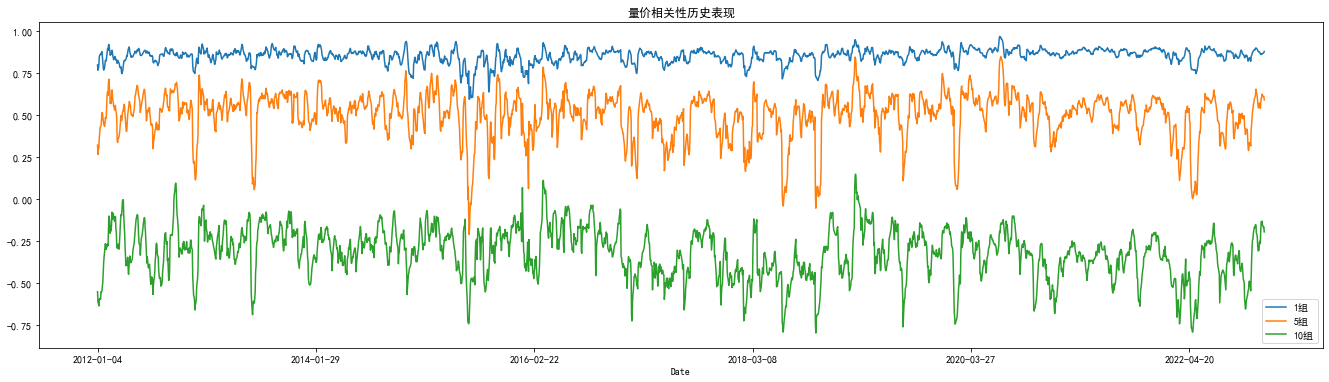

In [242]:
data1 = DF.loc[DF['因子分组']==1,['日期','量价相关性']].copy()
data1 = data1.groupby('日期').mean()
data5 = DF.loc[DF['因子分组']==5,['日期','量价相关性']].copy()
data5 = data5.groupby('日期').mean()
data10 = DF.loc[DF['因子分组']==10,['日期','量价相关性']].copy()
data10 = data10.groupby('日期').mean()

fig,axe= plt.subplots(1,1,figsize=(23,6))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(500)) 
axe.plot(data1,label='1组')
axe.plot(data5,label='5组')
axe.plot(data10,label='10组')
axe.set_xlabel('Date')
plt.legend()
axe.set_title('量价相关性历史表现')

#### 计算市场平均收益率

In [25]:
DF_mean = DF.groupby('日期',as_index=False).transform('mean')
DF['市场未来15日平均收益率']  = DF_mean['未来15日收益率']
#DF.to_csv('行情_因子_市场均值.csv')
DF

,日期,开盘,收盘,涨跌幅,换手率,代码,行业,未来15日收益率,前一个月平均日涨幅,前三个月平均日涨幅,月度日均换手率,量价相关性,日内rank,日内count,因子截面排名分位数,因子分组,市场未来15日平均收益率
62,2017-05-31,78.05,78.05,-9.98,25.38,300526,纺织服装,-19.295324,-1.169048,3.540794,15.599524,0.186310,1574.0,2913,54.033642,6.0,2.774092
63,2017-06-01,70.27,70.27,-9.97,4.53,300526,纺织服装,-8.367724,-2.120000,2.684127,15.408095,0.320601,1245.0,2907,42.827657,5.0,4.669097
64,2017-06-02,63.25,63.25,-9.99,1.41,300526,纺织服装,-0.316206,-2.613333,2.366984,13.660952,0.431573,970.0,2904,33.402204,4.0,6.063984
65,2017-06-05,60.17,63.97,1.14,34.41,300526,纺织服装,1.196610,-2.168571,2.226667,14.075714,-0.007648,2060.0,2899,71.058986,8.0,4.168972
66,2017-06-06,61.15,63.15,-1.28,24.62,300526,纺织服装,7.130008,-2.129524,2.047460,14.503810,-0.118168,2332.0,2899,80.441532,9.0,4.923293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,2020-05-28,2.84,2.84,-4.05,0.57,601558,未分类,8.450704,-3.640952,-1.640794,0.446190,-0.013357,3368.0,3799,88.654909,9.0,6.100642
2228,2020-05-29,2.72,2.84,0.00,7.01,601558,未分类,11.029412,-3.458571,-1.629206,0.749048,-0.320713,3649.0,3795,96.152833,10.0,6.523617
2229,2020-06-01,2.84,2.84,0.00,2.71,601558,未分类,8.450704,-3.648571,-1.570952,0.694286,-0.390764,3687.0,3795,97.154150,10.0,5.333570
2230,2020-06-02,2.90,2.96,4.23,2.19,601558,未分类,10.344828,-3.629524,-1.467619,0.763333,-0.475925,3736.0,3802,98.264072,10.0,3.041522


#### 因子分组风险特征

In [30]:
#DF.to_csv('行情_因子_市场均值.csv')
DF[DF.isnull().T.any()]

,日期,开盘,收盘,涨跌幅,换手率,代码,行业,未来15日收益率,前一个月平均日涨幅,前三个月平均日涨幅,月度日均换手率,量价相关性,日内rank,日内count,因子截面排名分位数,因子分组,市场未来15日平均收益率


In [29]:
#df_return_analysis = DF.groupby('因子分组').mean()
df_return_analysis.reset_index(drop=False,inplace=True)
df_return_analysis

,开盘,收盘,涨跌幅,换手率,未来15日收益率,前一个月平均日涨幅,前三个月平均日涨幅,月度日均换手率,量价相关性,日内rank,日内count,因子截面排名分位数,市场未来15日平均收益率
因子分组,,,,,,,,,,,,,
1.0,106.076273,106.825089,0.505261,5.163300,NaN,0.316090,0.137409,4.012206,0.856375,169.851518,3392.469505,5.007203,NaN
2.0,110.661629,111.082996,0.186933,3.486753,NaN,0.161836,0.086738,3.409158,0.748819,508.748273,3392.123140,14.997824,NaN
3.0,115.815536,116.036841,0.111059,2.942720,0.849817,0.107633,0.067044,3.052381,0.665712,847.944749,3392.064976,24.997794,NaN
4.0,114.720779,114.902735,0.066240,2.620919,NaN,0.071111,0.053133,2.801525,0.585173,1187.180702,3392.151201,34.997739,NaN
5.0,119.423783,119.483965,0.032087,2.383851,0.961219,0.053210,0.049584,2.600561,0.501428,1526.319804,3392.212934,44.994428,NaN
6.0,120.810720,120.886378,-0.000718,2.208054,NaN,0.037831,0.051907,2.442955,0.409867,1865.407316,3391.963587,54.994552,NaN
7.0,120.307866,120.486721,-0.031067,2.069764,NaN,0.010471,0.037665,2.304828,0.304673,2204.785812,3392.086527,64.997777,NaN
8.0,117.717729,117.727726,-0.059565,1.957577,NaN,0.000475,0.046599,2.188572,0.176459,2544.026082,3392.129641,74.997723,NaN
9.0,123.677909,123.551766,-0.101721,1.865779,NaN,-0.015361,0.064860,2.077062,0.002427,2883.177254,3392.058475,84.997692,NaN


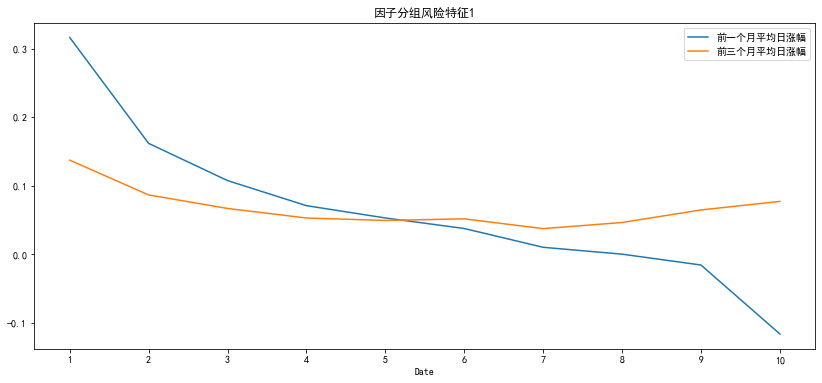

In [64]:
fig,axe= plt.subplots(1,1,figsize=(14,6))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1)) 
axe.plot(df_return_analysis['前一个月平均日涨幅'],label='前一个月平均日涨幅')
axe.plot(df_return_analysis['前三个月平均日涨幅'],label='前三个月平均日涨幅')
axe.set_xlabel('Date')
axe.set_title('因子分组风险特征1')
plt.legend()

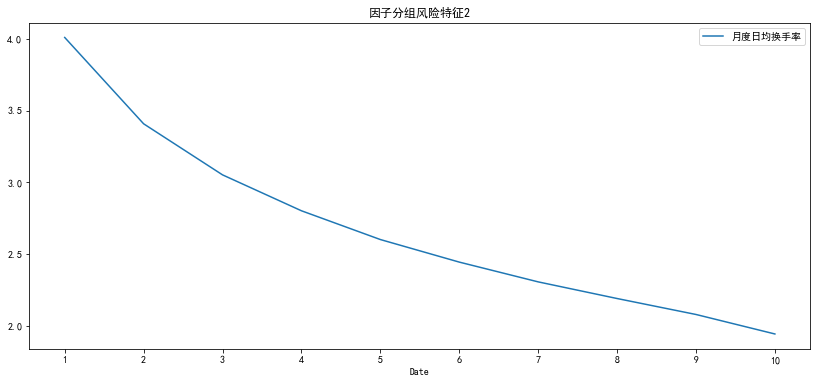

In [66]:
fig,axe= plt.subplots(1,1,figsize=(14,6))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1)) 
axe.plot(df_return_analysis['月度日均换手率'],label='月度日均换手率')
axe.set_xlabel('Date')
axe.set_title('因子分组风险特征2')
plt.legend()

### IC 与RANKIC

#### 计算IC,RANKIC

In [43]:
def get_ic_rankic(factor,rank,returns):
    IC = np.corrcoef(factor,returns)[0,1]
    RANKIC = np.corrcoef(rank,returns)[0,1]*(-1)#因子值越大排名越大
    return IC,RANKIC
df_IC = pd.DataFrame(columns = ['日期','IC','RANKIC'])

date_list = list(DF['日期'].unique())
for i in trange(len(date_list)):
    date = date_list[i]
    tempdf = DF.loc[DF['日期']==date,['量价相关性','日内rank','未来15日收益率']].copy()
    IC,RANKIC = get_ic_rankic(tempdf['量价相关性'],tempdf['日内rank'],tempdf['未来15日收益率'])
    df_IC.loc[len(df_IC),:] = [date,IC,RANKIC]
df_IC.dropna(how='any',inplace=True)    
df_IC    

 29%|██▉       | 769/2673 [08:19<20:01,  1.58it/s]C:\Download\lib\site-packages\numpy\lib\function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
100%|██████████| 2673/2673 [29:19<00:00,  1.52it/s]


,日期,IC,RANKIC
0,2017-05-31,-0.092741,-0.092597
1,2017-06-01,-0.053536,-0.051145
2,2017-06-02,-0.055674,-0.056657
3,2017-06-05,-0.134933,-0.135201
4,2017-06-06,-0.10834,-0.112011
...,...,...,...
2668,2012-01-11,0.071383,0.054322
2669,2012-01-12,0.139474,0.125643
2670,2012-01-13,0.125004,0.114729
2671,2012-01-16,0.011886,-0.000138


#### 因子IC分位数统计

In [78]:
df_IC['IC_rank'] = df_IC['IC'].rank(ascending=0)/len(df_IC)*100
df_IC['RANKIC_rank'] = df_IC['RANKIC'].rank(ascending=0)/len(df_IC)*100
df_IC['IC_rank'] = df_IC['IC_rank'].apply(lambda x:min(x//10+1,10))
df_IC['RANKIC_rank'] = df_IC['RANKIC_rank'].apply(lambda x:min(x//10+1,10))
df_IC_analysis = df_IC.groupby('IC_rank').max()[['IC']]
df_IC_analysis['分位数%'] = df_IC_analysis.index*10
df_RANKIC_analysis = df_IC.groupby('RANKIC_rank').max()[['RANKIC']]
df_RANKIC_analysis['分位数%'] = df_RANKIC_analysis.index*10
IC_analysis = pd.merge(df_RANKIC_analysis,df_IC_analysis,on='分位数%')[['分位数%','IC','RANKIC']]
IC_analysis

,分位数%,IC,RANKIC
0,10.0,0.201753,0.205614
1,20.0,0.065234,0.066850
2,30.0,0.033828,0.031542
3,40.0,0.012520,0.010714
4,50.0,-0.006327,-0.007201
5,60.0,-0.022880,-0.024187
6,70.0,-0.039560,-0.040959
7,80.0,-0.060035,-0.060776
8,90.0,-0.082093,-0.084188
9,100.0,-0.115427,-0.115506


### 回测

#### 多空组合表现

In [83]:
df_adjust_date_ = df_adjust_date.copy()
df_adjust_date_['日期'] = df_adjust_date_['日期'].apply(lambda x:str(x)[:10])
df_adjust_date_

,日期,addate
0,2012-01-04,1
1,2012-01-05,0
2,2012-01-06,0
3,2012-01-09,0
4,2012-01-10,0
...,...,...
2668,2022-12-26,0
2669,2022-12-27,0
2670,2022-12-28,0
2671,2022-12-29,1


In [104]:
df_BT = pd.merge(DF,df_adjust_date_,on='日期',how='inner')

In [105]:
df_BT = df_BT[['日期','因子分组','未来15日收益率','市场未来15日平均收益率','addate','代码']].copy()
df_BT = df_BT.loc[df_BT['addate']==1,:].copy()
df_BT['bt'] = 0
df_BT.loc[df_BT['因子分组']==1,'bt']=1
df_BT.loc[df_BT['因子分组']==10,'bt']=-1
df_BT['day_return'] = df_BT['未来15日收益率']*df_BT['bt']
df_backtest = df_BT.groupby('日期').mean()
df_backtest = df_backtest[['市场未来15日平均收益率','day_return']].copy()
df_backtest['day_return_'] = (df_backtest['day_return']+100)/100
df_backtest['净值'] = df_backtest['day_return_'].cumprod()
df_backtest

,市场未来15日平均收益率,day_return,day_return_,净值
日期,,,,
2012-01-04,-0.998255,-0.237853,0.997621,0.997621
2012-01-19,13.297630,-0.612996,0.993870,0.991506
2012-02-03,12.835952,0.160174,1.001602,0.993094
2012-02-20,6.712502,0.055817,1.000558,0.993649
2012-03-06,-2.954280,-0.108518,0.998915,0.992570
...,...,...,...,...
2022-10-28,6.609415,0.248060,1.002481,0.851608
2022-11-14,1.970627,0.142342,1.001423,0.852820
2022-11-29,-0.982119,0.317528,1.003175,0.855528


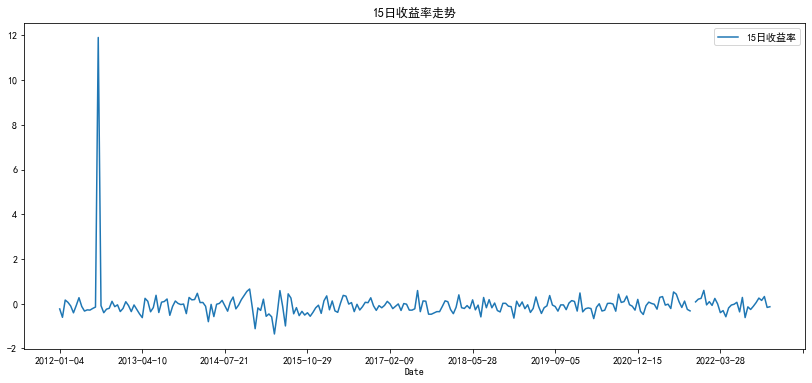

In [106]:
fig,axe= plt.subplots(1,1,figsize=(14,6))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30)) 
axe.plot(df_backtest['day_return'],label='15日收益率')
axe.set_xlabel('Date')
axe.set_title('15日收益率走势')
plt.legend()

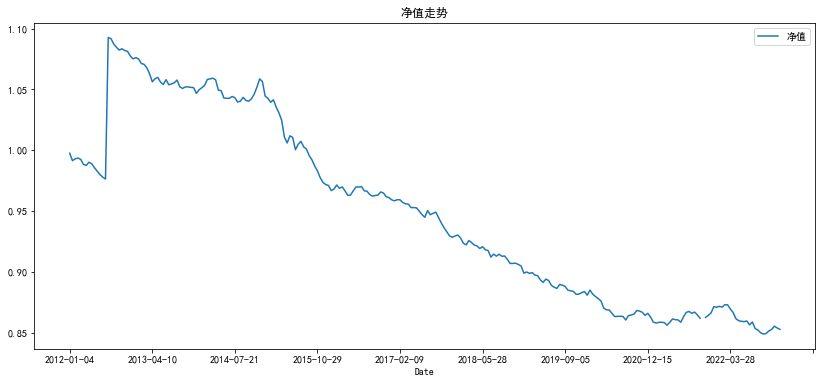

In [107]:
fig,axe= plt.subplots(1,1,figsize=(14,6))
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(30)) 
axe.plot(df_backtest['净值'],label='净值')
axe.set_xlabel('Date')
axe.set_title('净值走势')
plt.legend()